In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trade_data
from passivbot import load_settings
from backtester import *

In [3]:
plt.rcParams['figure.figsize'] = [21, 13]
pd.set_option('precision', 10)

In [4]:
settings = load_settings('default')
settings

{'quot': 'BTC',
 'coins_long': ['ADA',
  'ATOM',
  'BAT',
  'BCH',
  'BNB',
  'DASH',
  'EOS',
  'ETC',
  'ETH',
  'IOST',
  'IOTA',
  'LINK',
  'LTC',
  'MATIC',
  'NEO',
  'ONT',
  'QTUM',
  'RVN',
  'TRX',
  'VET',
  'XLM',
  'XMR',
  'XRP',
  'XTZ',
  'ZEC'],
 'coins_shrt': ['ADA',
  'ATOM',
  'BAT',
  'BCH',
  'DASH',
  'EOS',
  'ETC',
  'ETH',
  'IOST',
  'IOTA',
  'LINK',
  'LTC',
  'MATIC',
  'NEO',
  'ONT',
  'QTUM',
  'RVN',
  'TRX',
  'VET',
  'XLM',
  'XMR',
  'XRP',
  'XTZ',
  'ZEC'],
 'do_not_borrow': ['BNB'],
 'profit_pct': 0.0025,
 'account_equity_pct_per_trade': 0.0006,
 'account_equity_pct_per_hour': 0.0045,
 'hours_rolling_small_trade_window': 1.0,
 'bnb_buffer': 50.3,
 'max_memory_span_days': 30,
 'snapshot_timestamp_millis': 0,
 'ema_spans_minutes': [15, 25, 40, 64, 102, 164, 263, 421, 675, 1080],
 'user': 'default'}

In [5]:
fee = 1 - 0.0675 * 0.01 # vip1


# modify settings here


#settings['profit_pct'] = 0.0025

#settings['account_equity_pct_per_trade'] = 0.0006

#settings['account_equity_pct_per_hour'] = 0.0045

#settings['max_memory_span_days'] = 30

#settings['ema_spans_minutes'] = [15, 25, 40, 64, 102, 164, 263, 421, 675, 1080]
print(settings['account_equity_pct_per_trade'] * 60)

0.036


In [6]:
symbols = [f'{c}/BTC' for c in settings['coins_long']]
symbols = sorted(symbols)
n_days = 30 * 7
symbols = [s for s in symbols if not any(s.startswith(c) for c in ['VET', 'IOST'])]
symbols

['ADA/BTC',
 'ATOM/BTC',
 'BAT/BTC',
 'BCH/BTC',
 'BNB/BTC',
 'DASH/BTC',
 'EOS/BTC',
 'ETC/BTC',
 'ETH/BTC',
 'IOTA/BTC',
 'LINK/BTC',
 'LTC/BTC',
 'MATIC/BTC',
 'NEO/BTC',
 'ONT/BTC',
 'QTUM/BTC',
 'RVN/BTC',
 'TRX/BTC',
 'XLM/BTC',
 'XMR/BTC',
 'XRP/BTC',
 'XTZ/BTC',
 'ZEC/BTC']

In [22]:
# set no_download to True to load faster if already downloaded ohlcvs
high_low_means = load_hlms(symbols, n_days, no_download=False)

In [8]:
df = add_emas(high_low_means, settings['ema_spans_minutes'])
print(f'n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:2f}')

n_days 209.997222


In [9]:
balance_list, lentr, sentr, lexit, sexit, lexitpl, sexitpl = backtest(df, settings)

100.00% acc equity quot: 1.400428  avg daily gain: 1.001605

In [10]:
# balances are in terms of quot
bldf = pd.DataFrame(balance_list).set_index('timestamp')

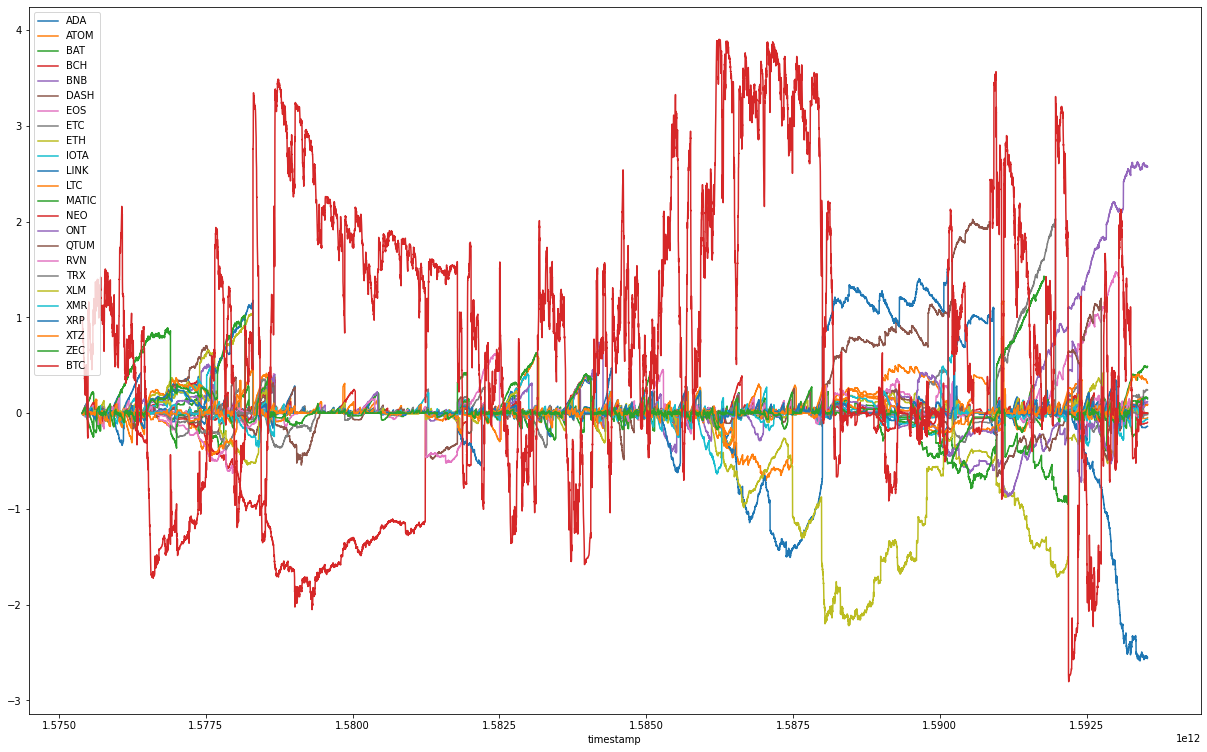

In [11]:
bldf.drop(['acc_equity_quot', 'acc_debt_quot'], axis=1).iloc[::10].plot()

average daily gain 1.00160507


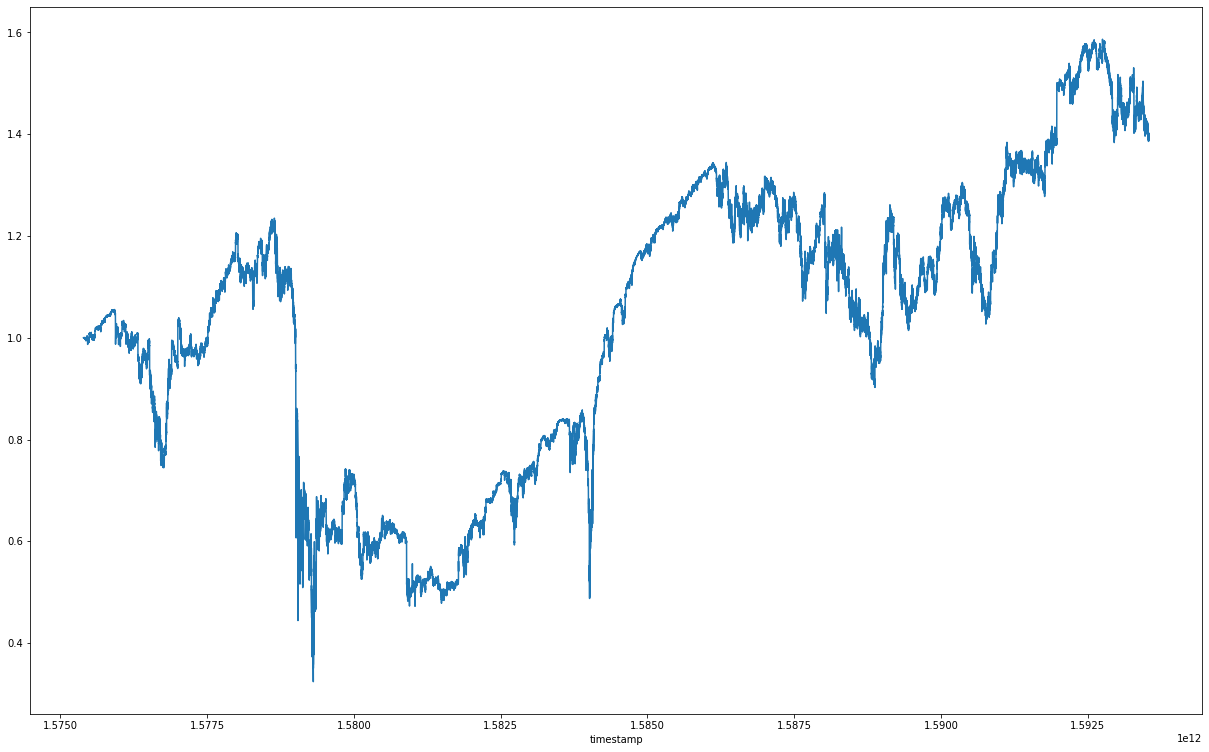

In [12]:
start_equity = bldf.acc_equity_quot.iloc[0]
end_equity = bldf.acc_equity_quot.iloc[-1]
n_days = (bldf.index[-1] - bldf.index[0]) / 1000 / 60 / 60 / 24
avg_daily_gain = (end_equity / start_equity)**(1 / n_days)
print('average daily gain', round(avg_daily_gain, 8))
bldf.acc_equity_quot.plot()

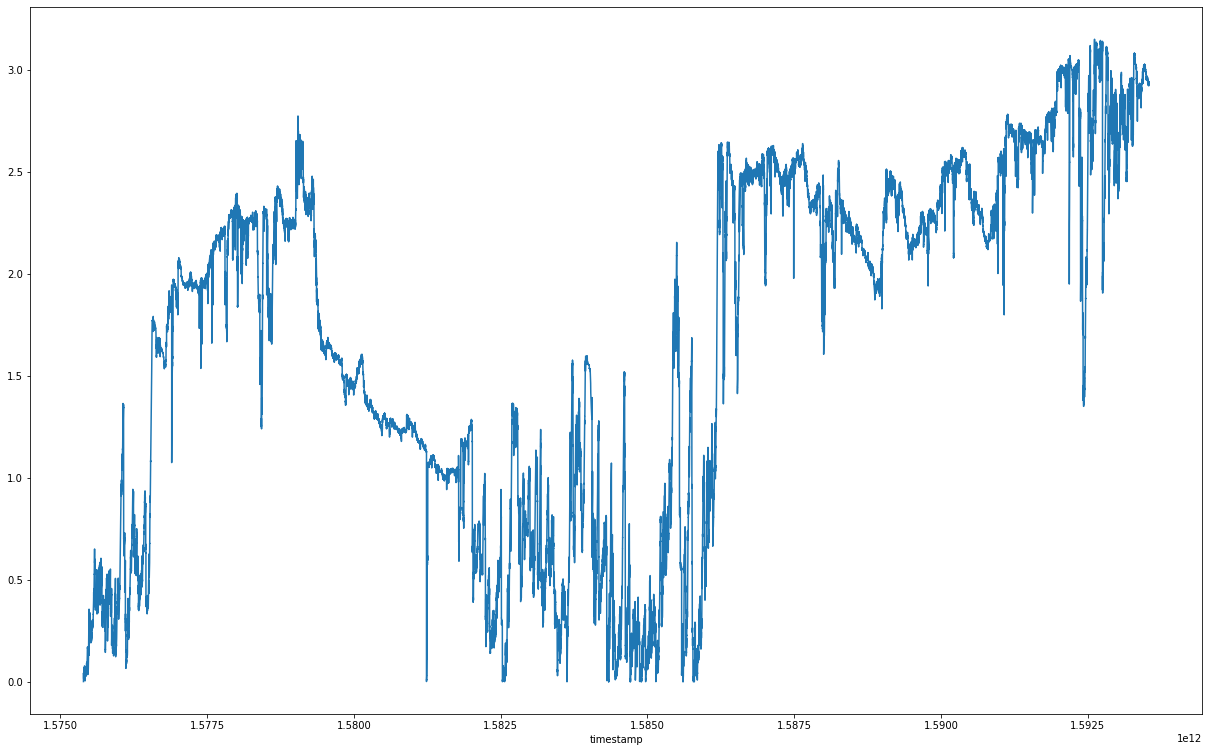

In [13]:
bldf.acc_debt_quot.plot()

In [14]:
sum_vol = 0.0
for s in symbols:
    s_ = s.replace('/', '_')
    vol = sum([e['price'] * e['amount'] for e in lentr[s_]])
    vol += sum([e['price'] * e['amount'] for e in sentr[s_]])
    vol += sum([e['price'] * e['amount'] for e in lexit[s_]])
    vol += sum([e['price'] * e['amount'] for e in sexit[s_]])
    sum_vol += vol
    print(s, vol)
print('approx monthly vol', sum_vol / n_days * 30)

ADA/BTC 48.5215603889234
ATOM/BTC 45.93288985826587
BAT/BTC 45.501944310119
BCH/BTC 44.277112927929444
BNB/BTC 43.86575030322204
DASH/BTC 47.729061689632
EOS/BTC 44.08479954293688
ETC/BTC 44.10245749795985
ETH/BTC 43.37518539079513
IOTA/BTC 42.96749822934081
LINK/BTC 47.41443630231668
LTC/BTC 42.70539398366373
MATIC/BTC 49.64135652902635
NEO/BTC 41.43837446860076
ONT/BTC 43.776957225812936
QTUM/BTC 40.14704635532076
RVN/BTC 50.113124189015416
TRX/BTC 49.94774148605498
XLM/BTC 44.80957448688972
XMR/BTC 42.9582148919543
XRP/BTC 47.037585209375074
XTZ/BTC 44.810375535165164
ZEC/BTC 42.21978904966615
approx monthly vol 148.19885028110755


In [15]:
# bag status at end
sorted([(round(e[1], 6), e[0]) for e in dict(bldf.iloc[-1]).items() if 'acc' not in e[0]])

[(-2.551344, 'LINK'),
 (-0.137506, 'ADA'),
 (-0.095583, 'NEO'),
 (-0.063967, 'XMR'),
 (-0.046828, 'ATOM'),
 (-0.01424, 'TRX'),
 (-0.01199, 'QTUM'),
 (0.0, 'BTC'),
 (0.0, 'DASH'),
 (0.0, 'ETH'),
 (0.0, 'IOTA'),
 (0.0, 'RVN'),
 (0.0, 'XLM'),
 (0.003703, 'BAT'),
 (0.086698, 'BCH'),
 (0.087638, 'LTC'),
 (0.101801, 'EOS'),
 (0.119946, 'ONT'),
 (0.148042, 'ZEC'),
 (0.159233, 'XRP'),
 (0.240721, 'ETC'),
 (0.314373, 'XTZ'),
 (0.487792, 'MATIC'),
 (2.57194, 'BNB')]

In [33]:
r = {}
for s in map(lambda x: x.replace('/', '_'), symbols):
    # all buys
    abdf = pd.DataFrame(sorted(lentr[s] + sexit[s], key=lambda x: x['timestamp'])).set_index('timestamp')

    # all sels
    asdf = pd.DataFrame(sorted(sentr[s] + lexit[s], key=lambda x: x['timestamp'])).set_index('timestamp')
    buy_cost = (abdf.price * abdf.amount).sum()
    sel_cost = (asdf.price * asdf.amount).sum()
    sum_cost = buy_cost + sel_cost
    buy_vwap = buy_cost / abdf.amount.sum()
    sel_vwap = sel_cost / asdf.amount.sum()
    diff = (sel_vwap / buy_vwap) * fee**2
    approx_profit = buy_cost * (diff * fee**2 - 1)
    r[s] = {'vol': sum_cost, 'svwap / bvwap': sel_vwap / buy_vwap,
            'vol * (sel_vwap / buy_vwap * fee**2 - 1)': vol * (sel_vwap / buy_vwap * fee**2 - 1)}

sum_vol = sum(r[s]['vol'] for s in r)
print('sum vol', sum_vol)
print('monthly vol', sum_vol / n_days * 30)
rdf = pd.DataFrame(r).T.sort_values('vol * (sel_vwap / buy_vwap * fee**2 - 1)')
rdf

sum vol 1037.3782298519866
monthly vol 148.1988502811076


,vol,svwap / bvwap,vol * (sel_vwap / buy_vwap * fee**2 - 1)
BCH_BTC,44.2771129279,0.9763424309,-1.0544471050
DASH_BTC,47.7290616896,0.9916996780,-0.4069423912
ZEC_BTC,42.2197890497,1.0003456026,-0.0424059032
ETH_BTC,43.3751853908,1.0018816151,0.0223567033
ETC_BTC,44.1024574980,1.0031373765,0.0753031355
NEO_BTC,41.4383744686,1.0036144205,0.0954166504
XMR_BTC,42.9582148920,1.0036234252,0.0957963147
ATOM_BTC,45.9328898583,1.0037024715,0.0991291279
LTC_BTC,42.7053939837,1.0039235974,0.1084524211
QTUM_BTC,40.1470463553,1.0039596425,0.1099721819


In [17]:
# analyze particular symbol
s = 'BNB_BTC'

In [18]:
ledf = pd.DataFrame(lentr[s]).set_index('timestamp')
sedf = pd.DataFrame(sentr[s]).set_index('timestamp')
lexitdf = pd.DataFrame(lexit[s]).set_index('timestamp')
sexitdf = pd.DataFrame(sexit[s]).set_index('timestamp')
lexitpdf = pd.DataFrame(lexitpl[s]).set_index('timestamp')
sexitpdf = pd.DataFrame(sexitpl[s]).set_index('timestamp')

In [19]:
# longest bag durations
d = 1000 * 60 * 60 * 24
for e in sorted(np.diff(lexitdf.index / d))[-10:]:
    print('long bag duration days', round(e, 2))
print()
for e in sorted(np.diff(sexitdf.index / d))[-10:]:
    print('shrt bag duration days', round(e, 2))

long bag duration days 2.39
long bag duration days 2.42
long bag duration days 2.87
long bag duration days 2.92
long bag duration days 2.94
long bag duration days 3.72
long bag duration days 3.92
long bag duration days 4.31
long bag duration days 7.34
long bag duration days 12.72

shrt bag duration days 2.48
shrt bag duration days 2.62
shrt bag duration days 3.02
shrt bag duration days 3.76
shrt bag duration days 3.82
shrt bag duration days 3.84
shrt bag duration days 4.42
shrt bag duration days 4.92
shrt bag duration days 9.95
shrt bag duration days 11.34


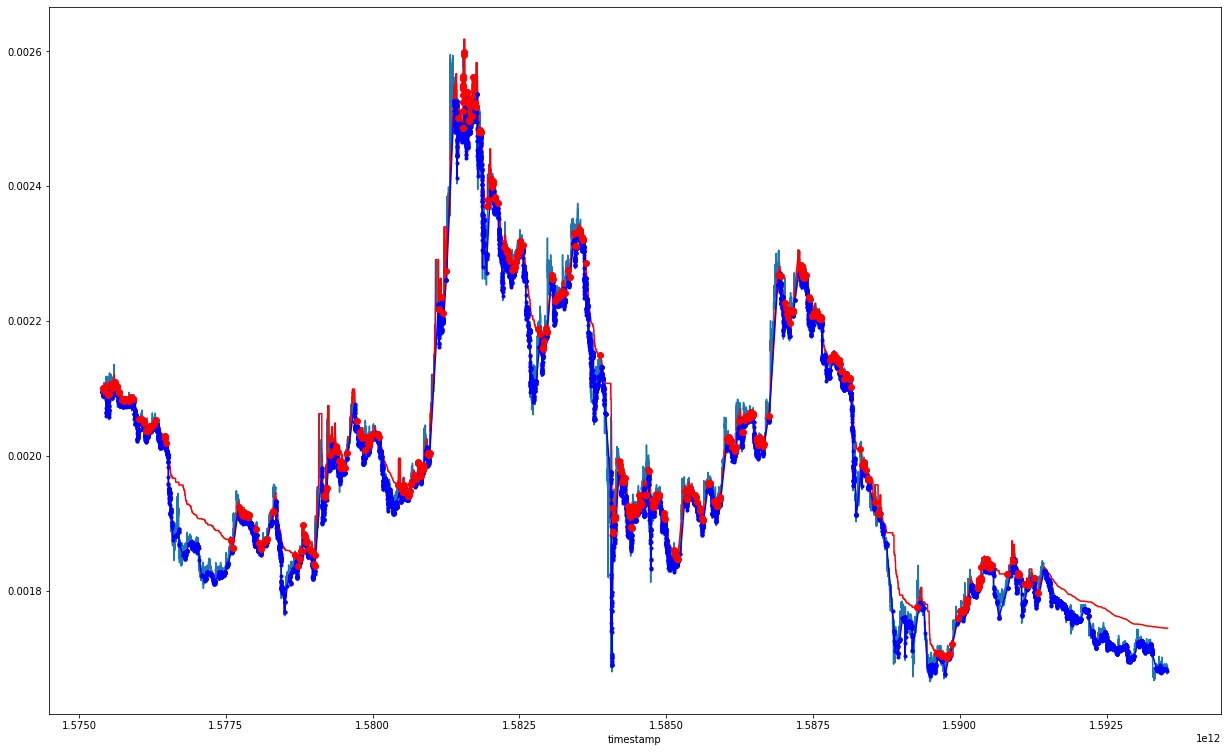

In [20]:
high_low_means[s + '_mean'].plot()
lexitpdf.price.plot(style='r-')
ledf.price.plot(style='b.-')
lexitdf.price.plot(style='ro')

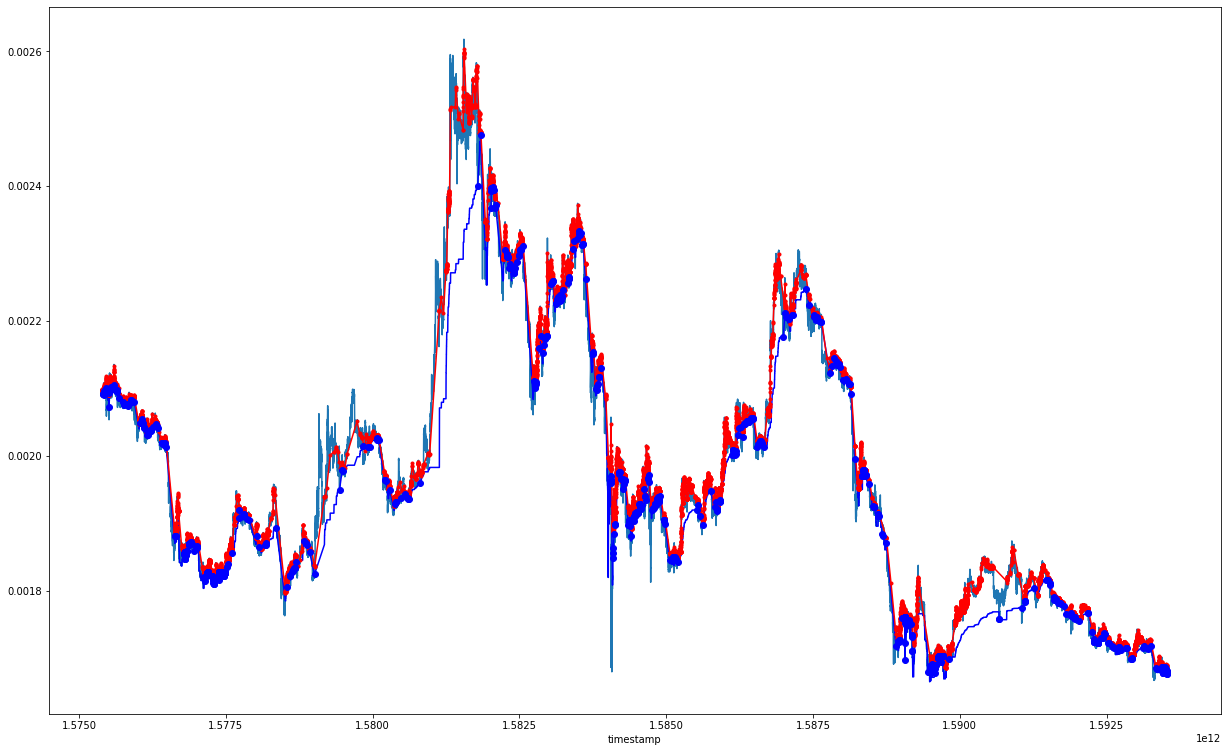

In [21]:
high_low_means[s + '_mean'].plot()
sexitpdf.price.plot(style='b-')
sedf.price.plot(style='r.-')
sexitdf.price.plot(style='bo')